In [1]:
from os.path import join
from glob import glob
import xarray as xr 
import matplotlib.pyplot as plt
import pyresample
from WoF_post.wofs.plotting.wofs_colors import WoFSColors
from WoF_post.wofs.plotting.wofs_levels import WoFSLevels
from matplotlib.colors import BoundaryNorm

import os,sys
path = os.getcwd()
sys.path.insert(0, os.getcwd())
from py_spectra import get_spectra2D_DCT

In [2]:
# TODO: Think about using patching solely due to difference in shapes 
# of the 3-km and 1-km grids.

def load_data(date, init_time, time_ind, ens_ind=1):
    #/work/brian.matilla/WOFS_2021/summary_files/WOFS_JET/WOFS_1km_downscaled/
    base_path = '/work/brian.matilla/WOFS_2021/summary_files/WOFS_JET/WOFS_1KM/'
    file_path = glob(join(base_path, date, init_time, f'wofs_ENS_{time_ind}*'))[0]
    ds_1km = xr.load_dataset(file_path, decode_times=False)
    dbz_1km = ds_1km['comp_dz'].values[ens_ind,:,:]
    
    base_path = '/work/mflora/SummaryFiles/'
    file_path = glob(join(base_path, date, init_time, f'wofs_ENS_{time_ind}*'))[0]
    ds_3km = xr.load_dataset(file_path, decode_times=False)
    dbz_3km = ds_3km['comp_dz'].values[ens_ind,:,:]
    
    return dbz_1km, dbz_3km, ds_1km, ds_3km

In [3]:
date = '20210504'
init_time = '2300'
time_ind = '03'
ens_ind = 4

dbz_1km, dbz_3km, ds_1km, ds_3km = load_data(date, init_time, time_ind, ens_ind)

In [4]:
import numpy as np
from scipy.fft import fft2, ifft2

class SpatialFilter:
    """SpatialFilter uses scipy.fft and a Butterworth filter to remove spatial scales above
    and below a given maximum and minimum resolution, respectively.
    
    Code is from thunderhoser (URL).
    
    Attributes
    ---------------
    grid_spacing : int 
        Grid spacing (in meters)
        
    min_resolution : int 
        Minimumal scales to preserve (in meters). 
        
    max_resolution : int (default=np.inf)
        Maximum scales to preserve (in meters).
        Default is infinity so that all large scales are preserved.
    
    filter_order : int (default=10)
        Filter order for the Butterworth filter.
    
    """
    TOLERANCE = 1e-6
    
    def __init__(self, grid_spacing, min_resolution, max_resolution=np.inf, filter_order=4):
        self.grid_spacing_ = grid_spacing
        self.min_resolution_ = min_resolution
        self.max_resolution_ = max_resolution 
        self.filter_order_ = filter_order

    def taper_spatial_data(self, spatial_data_matrix):
        """Tapers spatial data by putting zeros along the edge.
        M = number of rows in grid
        N = number of columns in grid
        :param spatial_data_matrix: M-by-N np array of real numbers.
        :return: spatial_data_matrix: Same but after tapering.
        """
        num_rows = spatial_data_matrix.shape[0]
        num_columns = spatial_data_matrix.shape[1]
    
        # If the number is even, make it odd
        row_pad = 1 if num_rows%2 == 0 else 0
        col_pad = 1 if num_columns%2 == 0 else 0

        padding_arg = (
            (row_pad, 0),
            (col_pad, 0)
        )

        spatial_data_matrix = np.pad(
            spatial_data_matrix, pad_width=padding_arg, mode='constant',
            constant_values=0.
        )

        return spatial_data_matrix


    def _get_spatial_resolutions(self, num_grid_rows, num_grid_columns):
        """Computes spatial resolution for each Fourier coefficient.
        M = number of rows in spatial grid
        N = number of columns in spatial grid
        Matrices returned by this method correspond to matrices of Fourier
        coefficients returned by `np.fft.fft2`.  The x-coordinate increases with
        column index, and the y-coordinate increases with row index.
        :param num_grid_rows: M in the above discussion.
        :param num_grid_columns: N in the above discussion.
        :param grid_spacing_metres: Grid spacing (for which I use "resolution" as a
            synonym).
        :return: x_resolution_matrix_metres: M-by-N np array of resolutions in
            x-direction.
        :return: y_resolution_matrix_metres: Same but for y-direction.
        """
        num_half_rows_float = float(num_grid_rows - 1) / 2
        num_half_rows = int(np.round(num_half_rows_float))

        num_half_columns_float = float(num_grid_columns - 1) / 2
        num_half_columns = int(np.round(num_half_columns_float))

        # Find resolutions in x-direction.
        unique_x_wavenumbers = np.linspace(
            0, num_half_columns, num=num_half_columns + 1, dtype=int
        )
        x_wavenumbers = np.concatenate((
            unique_x_wavenumbers, unique_x_wavenumbers[1:][::-1]
        ))
        x_wavenumber_matrix = np.expand_dims(x_wavenumbers, axis=0)
        x_wavenumber_matrix = np.repeat(
            x_wavenumber_matrix, axis=0, repeats=num_grid_rows
        )

        with np.errstate(divide='ignore'):
            x_grid_length_metres = self.grid_spacing_ * (num_grid_columns - 1)
            x_resolution_matrix_metres = (
            0.5 * x_grid_length_metres / x_wavenumber_matrix
            )

        # Find resolutions in y-direction.
        unique_y_wavenumbers = np.linspace(
            0, num_half_rows, num=num_half_rows + 1, dtype=int
        )
        y_wavenumbers = np.concatenate((
            unique_y_wavenumbers, unique_y_wavenumbers[1:][::-1]
        ))
        y_wavenumber_matrix = np.expand_dims(y_wavenumbers, axis=1)
        y_wavenumber_matrix = np.repeat(
            y_wavenumber_matrix, axis=1, repeats=num_grid_columns
        )
    
        with np.errstate(divide='ignore'):
            y_grid_length_metres = self.grid_spacing_ * (num_grid_rows - 1)
            y_resolution_matrix_metres = (
                0.5 * y_grid_length_metres / y_wavenumber_matrix
            )

        return x_resolution_matrix_metres, y_resolution_matrix_metres


    def apply_rectangular_filter(self, coefficient_matrix):
        """Applies rectangular band-pass filter to Fourier coefficients.
        M = number of rows in spatial grid
        N = number of columns in spatial grid
        :param coefficient_matrix: M-by-N np array of coefficients in format
            returned by `np.fft.fft2`.

        :return: coefficient_matrix: Same as input but maybe with some coefficients
            zeroed out.
        """

        # Do actual stuff.
        x_resolution_matrix_metres, y_resolution_matrix_metres = (
            self._get_spatial_resolutions(
            num_grid_rows=coefficient_matrix.shape[0],
            num_grid_columns=coefficient_matrix.shape[1],
            )
        )

        resolution_matrix_metres = np.sqrt(
            x_resolution_matrix_metres ** 2 + y_resolution_matrix_metres ** 2
        )

        coefficient_matrix[resolution_matrix_metres > self.max_resolution_] = 0.
        coefficient_matrix[resolution_matrix_metres < self.min_resolution_] = 0.
        
        return coefficient_matrix


    def apply_butterworth_filter(self, coefficient_matrix, ):
        """Applies Butterworth band-pass filter to Fourier coefficients.
        :param coefficient_matrix: See doc for `apply_rectangular_filter`.
        :return: coefficient_matrix: Same as input but after filtering.
        """

        # Determine horizontal, vertical, and total wavenumber for each Fourier
        # coefficient.
        x_resolution_matrix_metres, y_resolution_matrix_metres = (
            self._get_spatial_resolutions(
                num_grid_rows=coefficient_matrix.shape[0],
                num_grid_columns=coefficient_matrix.shape[1],
            )
        )

        x_wavenumber_matrix_metres01 = (2 * x_resolution_matrix_metres) ** -1
        y_wavenumber_matrix_metres01 = (2 * y_resolution_matrix_metres) ** -1
        wavenumber_matrix_metres01 = np.sqrt(
            x_wavenumber_matrix_metres01 ** 2 + y_wavenumber_matrix_metres01 ** 2
        )

        # High-pass part.
        if not np.isinf(self.max_resolution_):
            min_wavenumber_metres01 = (2 * self.max_resolution_metres_) ** -1
            ratio_matrix = wavenumber_matrix_metres01 / min_wavenumber_metres01
            gain_matrix = 1 - (1 + ratio_matrix ** (2 * self.filter_order_)) ** -1
            coefficient_matrix = coefficient_matrix * gain_matrix

        # Low-pass part.
        if self.min_resolution_ > self.grid_spacing_:
            max_wavenumber_metres01 = (2 * self.min_resolution_) ** -1
            ratio_matrix = wavenumber_matrix_metres01 / max_wavenumber_metres01
            gain_matrix = (1 + ratio_matrix ** (2 * self.filter_order_)) ** -1
            coefficient_matrix = coefficient_matrix * gain_matrix

        return coefficient_matrix


    def filter(self, data):
        """Applies a fourier transform, filters out smaller scales using a butterworth filter, 
        and then converts back into the original space
    
        Parameters
        --------------
        data : array-like of shape (NY, NX)
            Input data.
    
        grid_spacing : int
            Grid spacing (in meters)
        
        min_resolution : int 
            Minimal grid spacing to preserve. Scales below this grid spacing
            are filtered out. 
    
        Returns
        -----------
        array-like of shape (NY, NX)
            Data with scales below the minimal resolution filtered out. 
        """
        # Pad the data for the prior to filtering.
        data_pad = self.taper_spatial_data(data)

        # Fourier transform the data.
        coefficient_matrix = fft2(data_pad)

        # Apply the filtering in the transformed space.
        new_coef_mat = self.apply_butterworth_filter(coefficient_matrix)

        # Convert back to the original space (np.real converts from complex128 to float)
        return np.real(ifft2(new_coef_mat))

In [5]:
flt = SpatialFilter(grid_spacing=1000, min_resolution=3000)
data_filtered = flt.filter(dbz_1km)

In [6]:
# Make sure the 1-km and 3-km span the same lat/lon space. 
xlat = ds_1km['xlat'].values
xlat_min, xlat_max = np.min(xlat), np.max(xlat)

xlon = ds_1km['xlon'].values
xlon_min, xlon_max = np.min(xlon), np.max(xlon)

xlat_3km = ds_3km['xlat'].values
xlon_3km = ds_3km['xlon'].values

# lat = y, lon = x 
jmax = np.argmin(np.abs(xlat_3km[:,0] - xlat_max))
jmin = np.argmin(np.abs(xlat_3km[:,0] - xlat_min))

imax = np.argmin(np.abs(xlon_3km[0,:] - xlon_max))
imin = np.argmin(np.abs(xlon_3km[0,:] - xlon_min))

In [7]:
def resample(target_grid, original_grid, variable):
    '''
    Resamples (i.e., re-projects, re-grid) the original grid to the target grid 
    using a nearest neighborhood approach
    Args:
        target_grid, 2-tuple of 2D arrays of target latitude and longitude 
        original_grid, 2-tuple of 2D arrays of original latitude and longitude 
        variable, 2D array to be resampled
    Return:
        variable_nearest, 2D array of variable resampled to the target grid
    '''
    # Create a pyresample object holding the original grid
    orig_def = pyresample.geometry.SwathDefinition(lons=original_grid[1], lats=original_grid[0])

    # Create another pyresample object for the target grid
    targ_def = pyresample.geometry.SwathDefinition(lons=target_grid[1], lats=target_grid[0])

    variable_nearest = pyresample.kd_tree.resample_nearest(orig_def, variable, \
                    targ_def, radius_of_influence=50000, fill_value=None)

    return variable_nearest

In [8]:
data_3km_res = dbz_3km[jmin:jmax+1, imin:imax+1]

# Resample filtered 1km to the 3 km grid. 
data_sub = resample(target_grid=(xlat_3km, xlon_3km), 
                    original_grid=(xlat, xlon), 
                    variable=data_filtered[:-1, :-1])

# Since the 1 km data is smaller than the 3 km grid.
# We want to restrict the plot to 1 km lat/lon space. 
data_sub = data_sub[jmin:jmax+1, imin:imax+1]

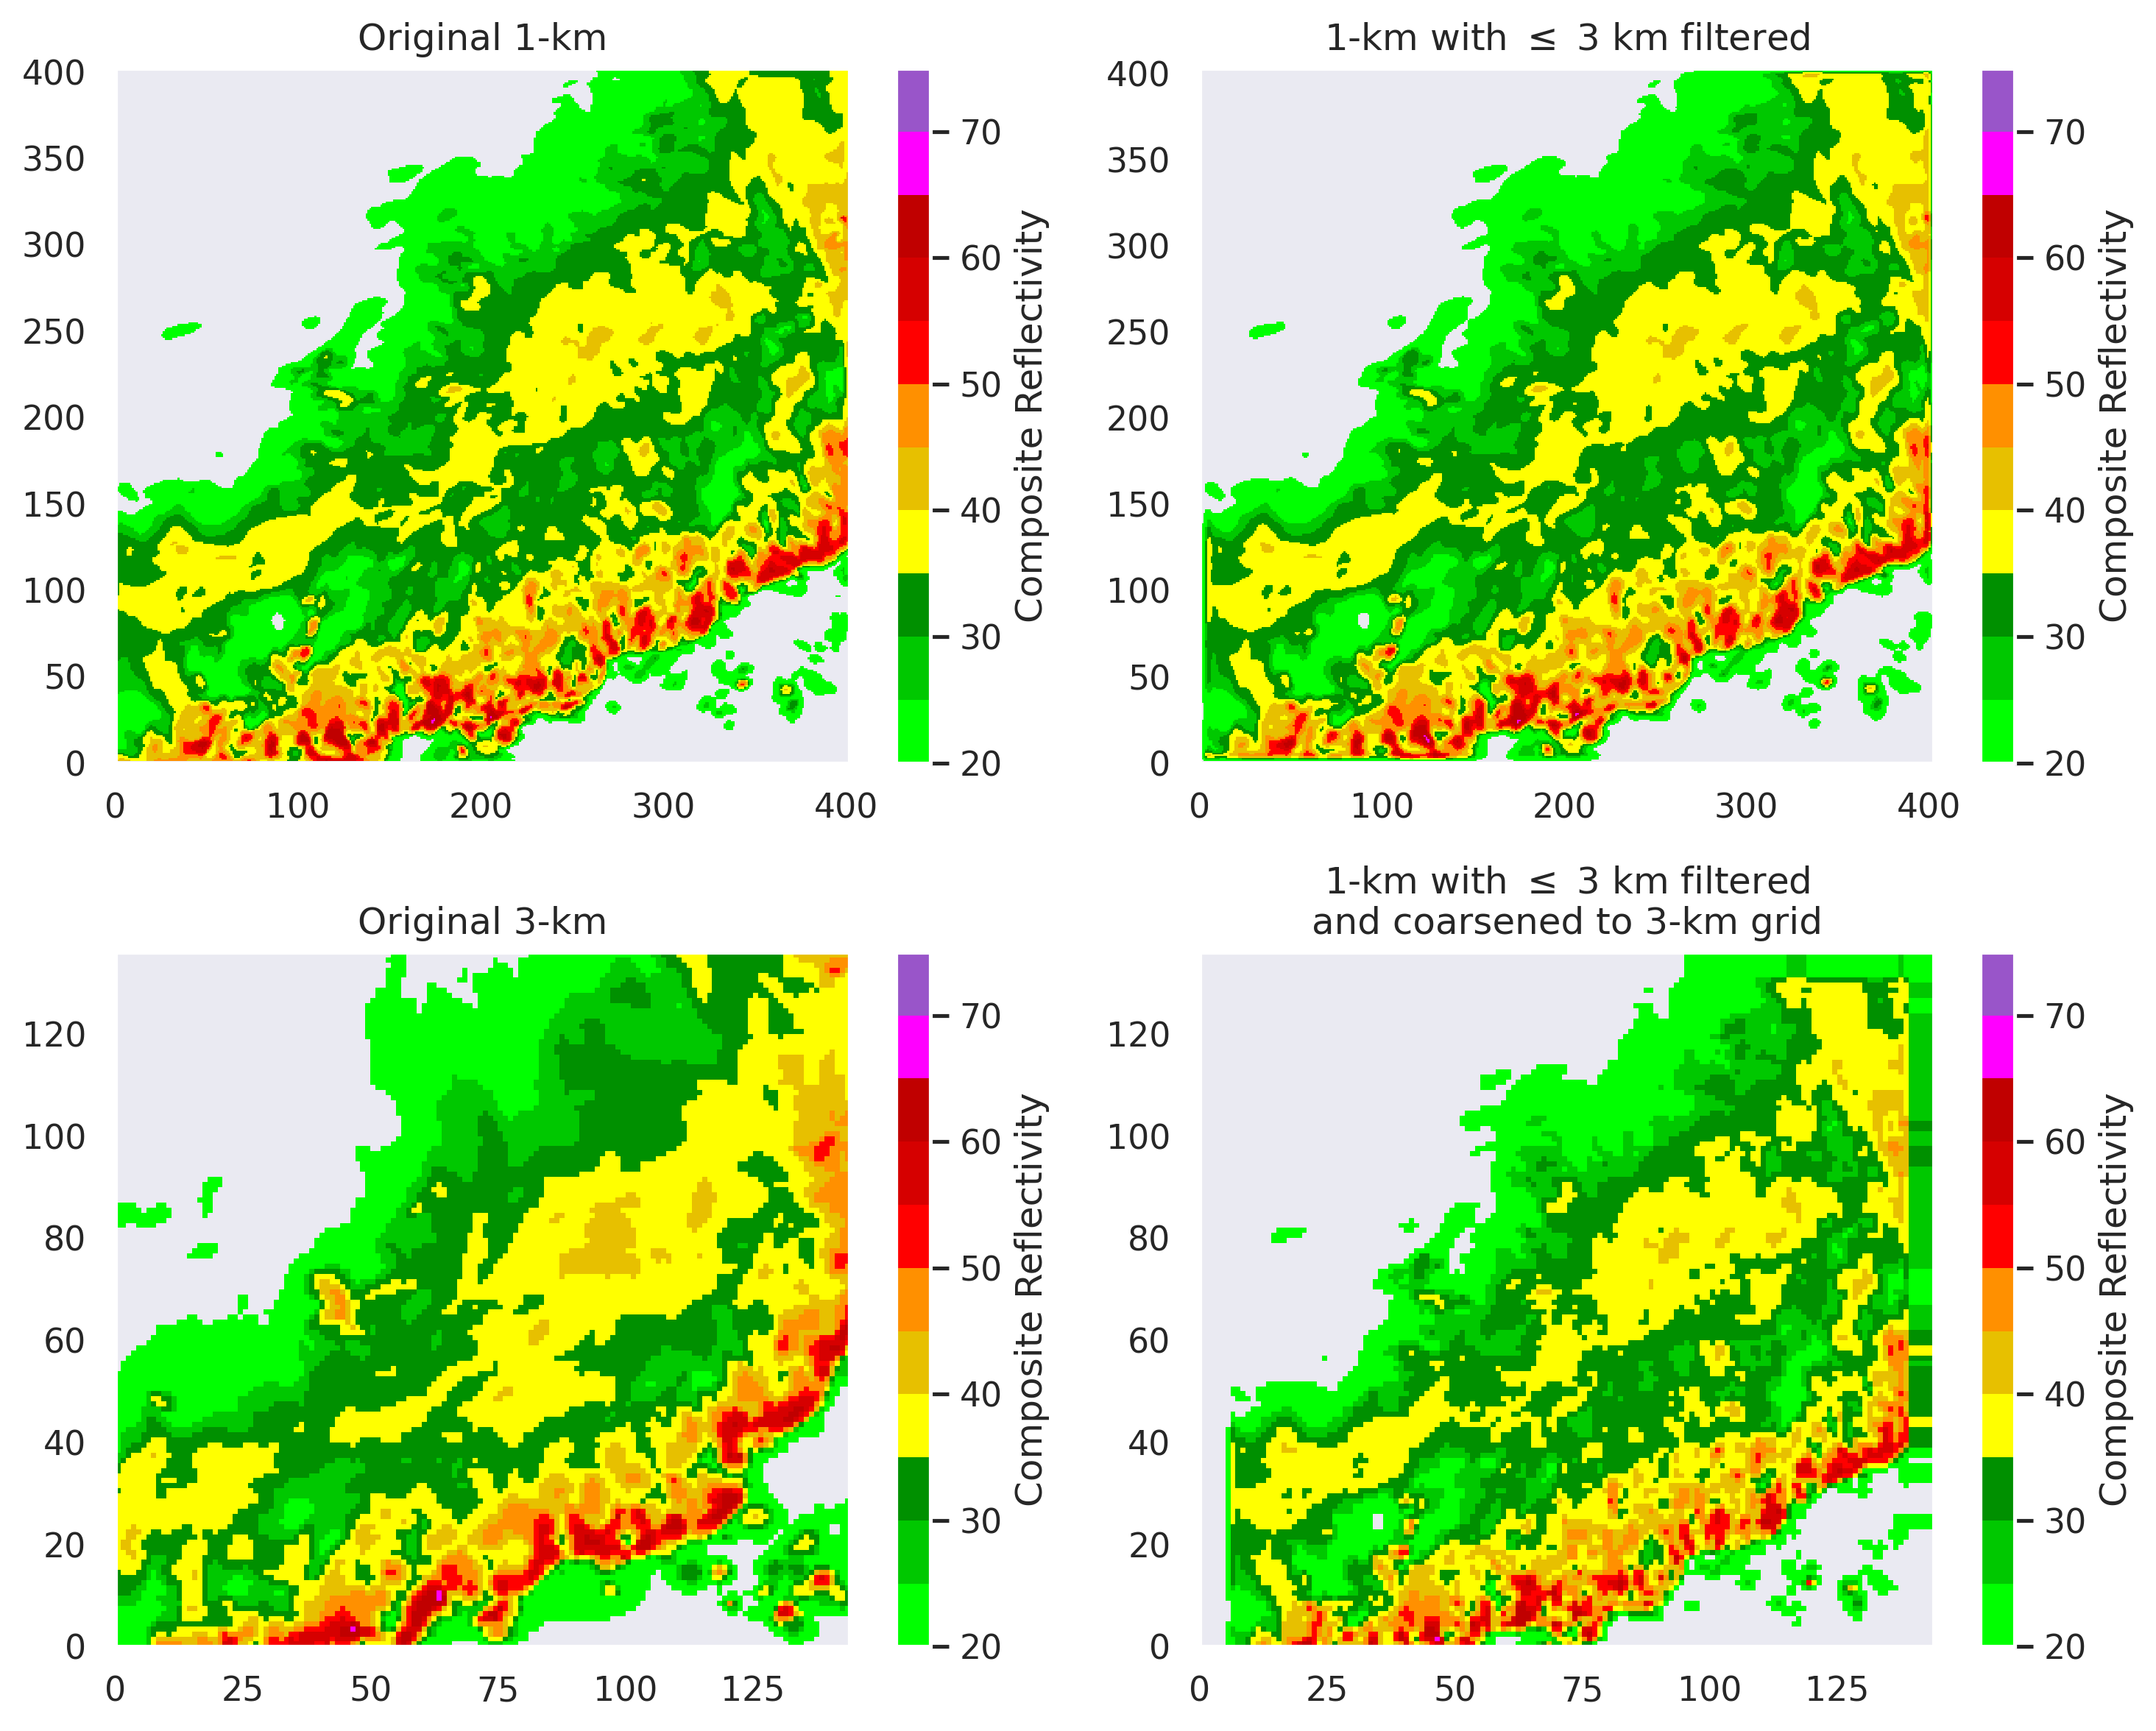

In [9]:
%matplotlib inline
import seaborn as sns
sns.set_theme()
fig,axes = plt.subplots(dpi=300, ncols=2, nrows=2, figsize=(10,8))

norm = BoundaryNorm(WoFSLevels.dz_levels_nws, 
                    ncolors=WoFSColors.nws_dz_cmap.N, clip=True)

datas = [dbz_1km, data_filtered, data_3km_res, data_sub]

titles = ['Original 1-km', r'1-km with $\leq$ 3 km filtered', 'Original 3-km', 
          r'1-km with $\leq$ 3 km filtered'+'\nand coarsened to 3-km grid']

for ax, img, title in zip(axes.flat, datas, titles):
    
    img = np.ma.masked_where(img<5, img)
    
    im = ax.pcolormesh(img, norm=norm, cmap=WoFSColors.nws_dz_cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label='Composite Reflectivity')
    ax.grid(False)
    
plt.tight_layout()

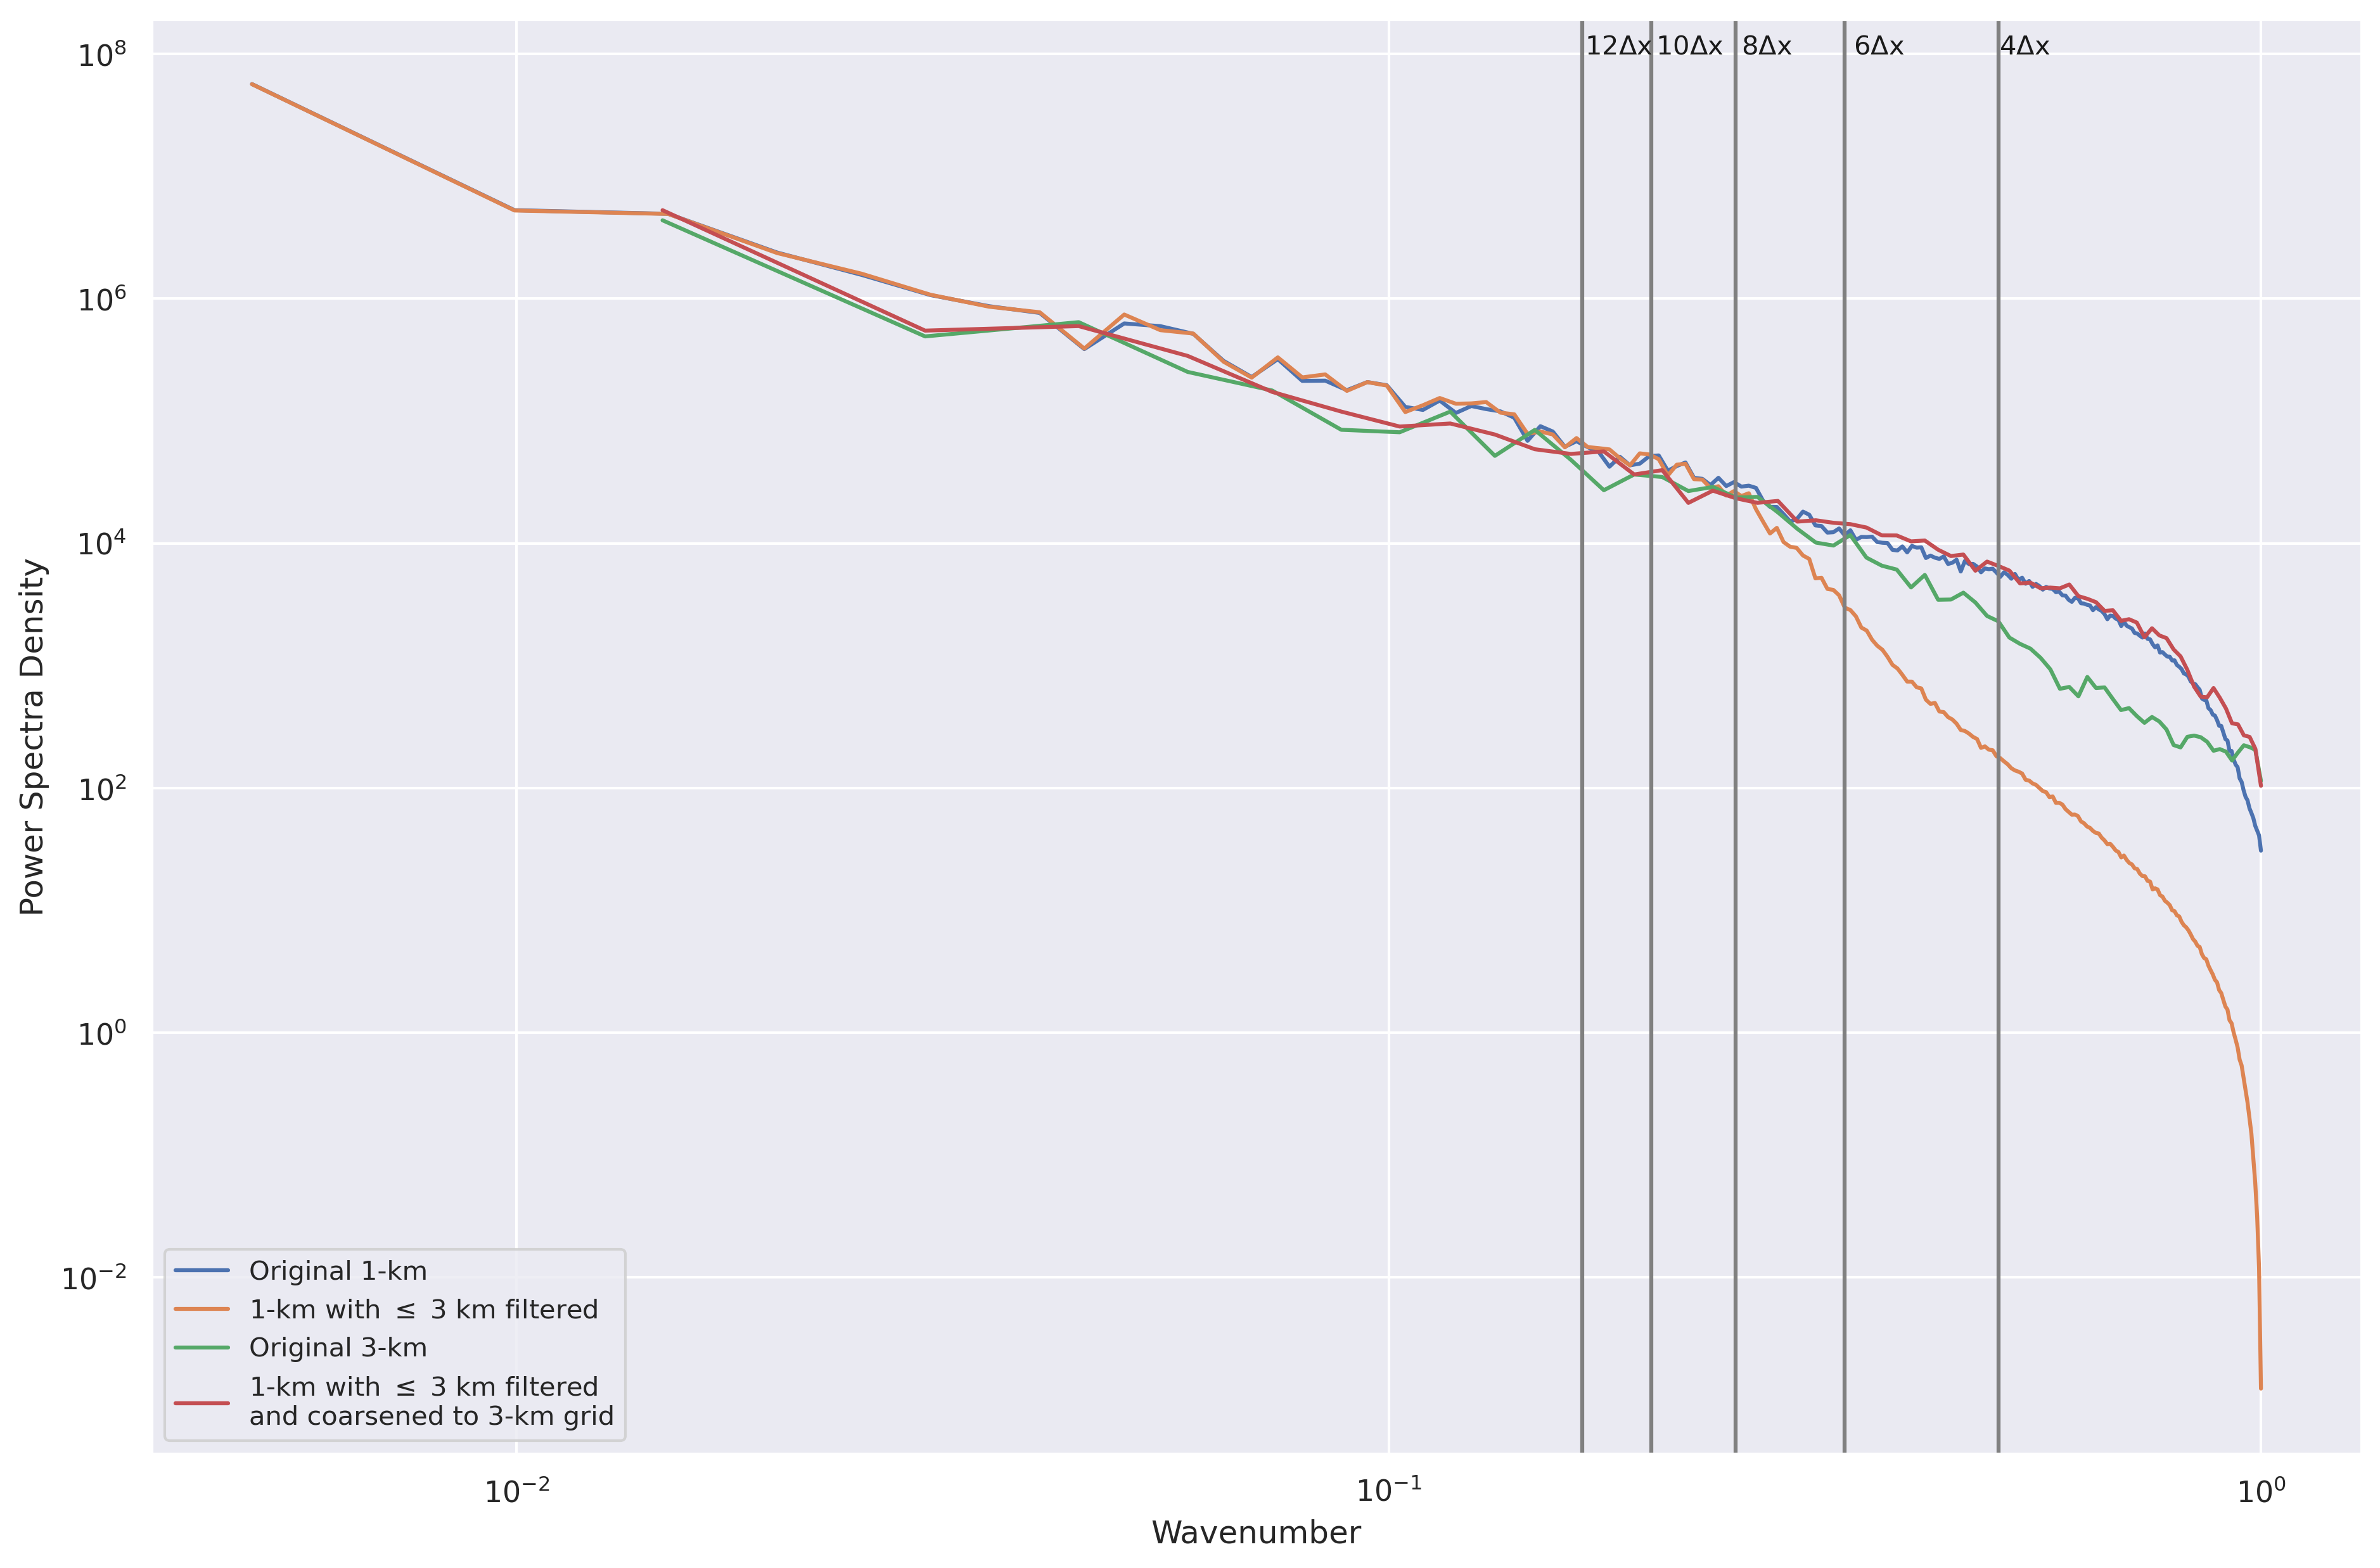

In [10]:
f, ax = plt.subplots(dpi=300, figsize=(15,10))
plt.tick_params(axis='both', which='minor')
dxs = [1000, 1000, 3000, 3000]
for data, dx, label in zip(datas, dxs, titles):
    kvals, PSbins, waven = get_spectra2D_DCT(data, dx=dx, dy=dx)
    ax.loglog(waven, PSbins, linestyle='-', label=label)
    

ylabel = 1e8
xoffset = [0.001, 0.0075, 0.0035, 0.0025, 0.001]
for n, w in enumerate([4.0, 6.0, 8.0, 10., 12.]):
    ax.axvline(x = 2.0/w, color = 'grey',)  
    ax.annotate(r"%d$\Delta$x" % w, xy=(2./w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=10)
ax.set_ylabel('Power Spectra Density')
ax.set_xlabel('Wavenumber')
ax.legend(fontsize=10)
#ax.xaxis.set_minor_locator(MultipleLocator(5))